
1. Audience: video publishing companies, producer companies would like to make TED video becomes popularity.
2. Metric: Number of views
3. Objective: create recommendation insights to perform the best TED talk to reach more success in public (in term of views), calculating the right mixture of main speaker, topic, duration of the talk, language, release time


**Questions want to find out:**
1. Topic that attract more views.
2. Rating of topic that attract more views: The way how to deliver the talks.
3. Time and Views: Which day and which month to publish videos.
4. Presentation Skills: Should speaker starts with question and make the talk funny by adding "laugh" in his/her talk? 

In [ ]:
#@title Importing necessary libraries
import time
import matplotlib.pyplot as plt
import matplotlib
import ast
import pandas as pd
import seaborn as sns
import warnings
import itertools
import plotly.express as px
import numpy as np
from datetime import datetime
from wordcloud import WordCloud,ImageColorGenerator
pd.plotting.register_matplotlib_converters()
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import calendar
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.facecolor'] = '#00000000'

## IMPORT DATA

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
main = pd.read_csv('gdrive/MyDrive/ted_main.csv')
transcripts = pd.read_csv('gdrive/MyDrive/transcripts.csv')

In [ ]:
for index, row in main.iterrows():
    if pd.isnull(row['speaker_occupation']):
        main['speaker_occupation'][index] = 'Other'

In [ ]:
main['published_date'] = pd.to_datetime(main['published_date'],unit='s')
main['published_date'] = main['published_date'].dt.strftime('%Y-%m-%d')

In [ ]:
main['film_date'] = pd.to_datetime(main['film_date'],unit='s')
main['published_date'] = pd.to_datetime(main['published_date'].str.strip(), format = '%Y-%m-%d')

In [ ]:
transcripts.head()


,transcript,url
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...


In [ ]:
df = pd.merge(main, transcripts, how='inner', on=['url'])

In [ ]:
df.shape

(2467, 18)

In [ ]:

df.loc[:,['comments','views']].describe()

,comments,views
count,2467.000000,2.467000e+03
mean,192.570734,1.740295e+06
std,284.829983,2.527086e+06
min,2.000000,1.558950e+05
25%,63.000000,7.875785e+05
50%,117.000000,1.149090e+06
75%,222.500000,1.736256e+06
max,6404.000000,4.722711e+07


Majority TED talks have views less than 5 million and most of these talks have views of about 1 million, as we can tell from the two number of views distribution figures below.

In [ ]:
#% of videos less than 5 million
(df[df['views'] < 5000000].shape[0])/df.shape[0]

0.9598702877989461

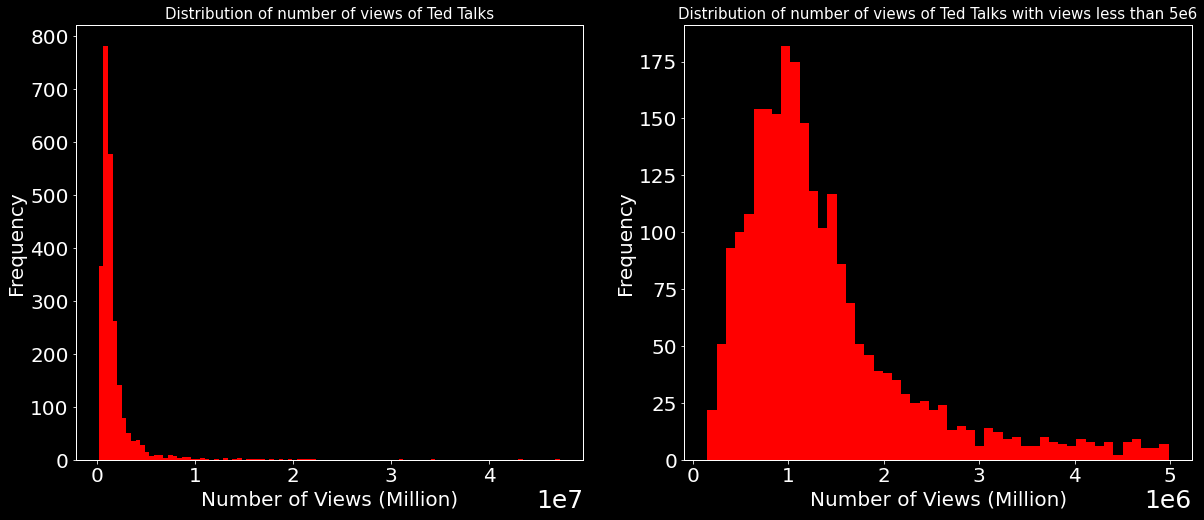

In [ ]:
plt.rcParams.update({'font.size': 25})
plt.style.use('dark_background')
plt.rcParams['axes.grid'] = False
fig=plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,2,1)
ax1.hist(df['views'], bins=100, color = 'red')
ax1.set_xlabel('Number of Views (Million)', fontsize=20)
ax1.set_ylabel('Frequency', fontsize=20)
ax1.set_title('Distribution of number of views of Ted Talks', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=20)
scale_x = 1e6
ax2 = fig.add_subplot(1,2,2)
ax2.hist(df[df['views']<5e6]['views'], bins=50, color = 'red')
ax2.set_xlabel('Number of Views (Million)', fontsize=20)
ax2.set_ylabel('Frequency', fontsize=20)
ax2.set_title('Distribution of number of views of Ted Talks with views less than 5e6', fontsize = 15)
ax2.tick_params(axis='both', which='major', labelsize=20)

Next, plot the top 10 and bottom 10 viewed TED talks. All of the top 10 viewed talks are belong to the most popular talks of all time on the TED official website, which serves as a way to test my definition of popularity. However, the exact order of popular talks are not the same.

In [ ]:
sort_by_view = df[['title', 'main_speaker','views', 'comments']].sort_values(by='views', ascending=False)
sort_by_view.reset_index(drop=True, inplace=True)
fig1 = px.bar(sort_by_view.head(10), x='views', y='title',width=1200,height=500, color_discrete_sequence = ['red'])
fig1.update_layout(
    title = 'Top 10 Viewed Ted Talks', 
    yaxis_title = 'Topic',
    plot_bgcolor = 'black'
    )
fig1.update_yaxes(showgrid=False,visible=True)
fig1.update_layout(
    template= 'plotly_dark')

In [ ]:
fig2 = px.bar(sort_by_view[-10:], x='views', y='title',width=1200,height=500, color_discrete_sequence = ['red'])
fig2.update_layout(
    title = 'Bottom 10 Viewed TED Talks', 
    yaxis_title = 'Topic',
    plot_bgcolor = 'black'
    )
fig2.update_yaxes(showgrid=False,visible=True)
fig2.update_layout(
    template= 'plotly_dark')

## ANALYSIS

### QUESTION: Ted Topics related to technology, entertainment and design are more popular?

TED — which stands for Technology, Entertainment and Design, naturally, so first question I want to know is is that topics related to technology, entertainment and design topics attract more views?

First, the topic of the talk is defined by their tag. The 'tag' variable is a long string, so we need to convert it to a list, and then create new columns for all tags available (416). Each talk will be assigned for corresponding tags as 1, while the rest of tags columns are 0.

In [ ]:
s = pd.Series(df['tags'].apply(eval))
s1 = pd.get_dummies(s.apply(pd.Series).stack()).sum(level=0)
df1 = pd.concat([df['title'], df['views'], s1], axis = 1)
df1.head()

,title,views,3d printing,AI,AIDS,Addiction,Africa,Alzheimer's,Anthropocene,Asia,...,wikipedia,wind energy,women,women in business,work,work-life balance,world cultures,writing,wunderkind,youth
0,Do schools kill creativity?,47227110,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Averting the climate crisis,3200520,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Simplicity sells,1636292,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Greening the ghetto,1697550,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The best stats you've ever seen,12005869,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df2 = df1[df1.columns.difference(['title', 'views'])]
df2.sum(axis=0).sort_values(ascending=False)[:10]

technology       712
science          548
global issues    490
culture          476
TEDx             418
design           408
business         338
entertainment    287
health           234
innovation       224
dtype: int64

In [ ]:
data_culture = df1[df1['culture'] ==1]
data_culture.head()

,title,views,3d printing,AI,AIDS,Addiction,Africa,Alzheimer's,Anthropocene,Asia,...,wikipedia,wind energy,women,women in business,work,work-life balance,world cultures,writing,wunderkind,youth
0,Do schools kill creativity?,47227110,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Averting the climate crisis,3200520,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Why we do what we do,20685401,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Letting go of God,3769987,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Behind the design of Seattle's library,967741,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data_culture.shape

(476, 418)

However, the above list is most given TED talks, not necessarily indicate their popularity. Therefore, for each talk, we can identify their topic tags and multiply with their number of views. Then for each topic tags, we use their total number of views of all related talks devided by the overall number of views of all talks. In this way, we are able to compare popularity of topics in terms of view rate.

In [ ]:
sum_of_views = df1[['views']].sum()
sum_of_views

views    4293308852
dtype: int64

In [ ]:
df3 = df1[df1.columns.difference(['title', 'views'])]
#The original data column type is int8, need to change it to int64 to accomodate large numbers
df3 = df3.astype(int)
df4 = pd.concat([df1['title'], df1['views'], df3], axis = 1)

In [ ]:
df4.head()

,title,views,3d printing,AI,AIDS,Addiction,Africa,Alzheimer's,Anthropocene,Asia,...,wikipedia,wind energy,women,women in business,work,work-life balance,world cultures,writing,wunderkind,youth
0,Do schools kill creativity?,47227110,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Averting the climate crisis,3200520,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Simplicity sells,1636292,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Greening the ghetto,1697550,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The best stats you've ever seen,12005869,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# each tag * views/total view numbers
for i in range(2, df4.shape[1]):
    for j in range(df4.shape[0]):
        if df4.iloc[j, i] != 0:
            df4.iloc[j, i]  = df4.iloc[j,i]*df4.loc[df4.index[j], 'views']

In [ ]:
df4.head()

,title,views,3d printing,AI,AIDS,Addiction,Africa,Alzheimer's,Anthropocene,Asia,...,wikipedia,wind energy,women,women in business,work,work-life balance,world cultures,writing,wunderkind,youth
0,Do schools kill creativity?,47227110,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Averting the climate crisis,3200520,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Simplicity sells,1636292,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Greening the ghetto,1697550,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The best stats you've ever seen,12005869,0,0,0,0,12005869,0,0,12005869,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df5 = df4[df4.columns.difference(['title', 'views'])]
out_view = df5.sum(axis=0)/4293308852

In [ ]:
top_view_rate  = pd.DataFrame(out_view.sort_values(ascending=False)[:10])
top_view_rate.reset_index(inplace=True)
top_view_rate.columns = ['Topic', 'View Rate']
top_view_rate 

,Topic,View Rate
0,culture,0.261790
1,technology,0.241961
2,science,0.206244
3,business,0.168889
4,TEDx,0.162800
5,global issues,0.146968
6,entertainment,0.133441
7,design,0.128265
8,psychology,0.110561
9,brain,0.104924


In [ ]:
fig3 = px.bar(top_view_rate, x='Topic', y='View Rate',width=1200,height=500, color_discrete_sequence = ['red'])
fig3.update_layout(
    title = 'Top 10 popular topic', 
    yaxis_title = 'Topic',
    plot_bgcolor = 'black'
    )
fig3.update_yaxes(showgrid=False,visible=True)
fig3.update_layout(
    template= 'plotly_dark')

Technology, entertainment and design are indeed belong to the top 10 popular topics.
The most top popular topics, however, are technology, culture, science and business.
TEDx is a Program which is designed to help communities, organizations and individuals to spark conversation and connection through local TED-like experiences. TEDx is a top tag as well.

Insight:
Technology, entertainment and design are belong to the top 10 popular topics, but technology, culture, science and global issues are the most top popular topics.


### QUESTION: Topics are more popular because they are informative rather than funny or surprising

Audiences have given ratings for each talk, for example, they may rate the talk as "inspiring", "courageous", or "beautiful".we will find out the connections between ratings and the most popular topics and answer the question of why some topics are more popular.

In [ ]:
s = df['ratings'].apply(eval)
s.head()

0    [{'id': 7, 'name': 'Funny', 'count': 19645}, {...
1    [{'id': 7, 'name': 'Funny', 'count': 544}, {'i...
2    [{'id': 7, 'name': 'Funny', 'count': 964}, {'i...
3    [{'id': 3, 'name': 'Courageous', 'count': 760}...
4    [{'id': 9, 'name': 'Ingenious', 'count': 3202}...
Name: ratings, dtype: object

In [ ]:
output = []
for i in range(df.shape[0]):
    x = {}
    for eachrating in s[i]:
        x[eachrating['name']] = eachrating['count']
    output.append(x)

In [ ]:
output = np.asarray(output)
s2 = pd.DataFrame(output)
s2 = s2[0].apply(pd.Series)

A summary of all ratings showed that "inspiring" are the most appeared word from the audiences, followed by "informative" and "fascinating".

In [ ]:
s2.sum().sort_values(ascending = False)

Inspiring       1310251
Informative      872197
Fascinating      780994
Persuasive       548601
Beautiful        472986
Courageous       411136
Funny            382827
Ingenious        374225
Jaw-dropping     365851
OK               201459
Unconvincing     131571
Longwinded        81013
Obnoxious         63515
Confusing         51890
dtype: int64

In [ ]:
df_h2b = pd.concat([df['title'], df['views'], df['comments'], s1, s2], axis = 1)

In [ ]:
alltheme = pd.DataFrame(index = s1.columns, columns = ['rating_1', 'rating_2', 'rating_3'])

for j in range(3, df_h2b.shape[1]-14):
    print('processing:', df_h2b.columns[j])
    eachtheme = pd.DataFrame(index = s2.index, columns = s2.columns)
    eachtheme.fillna(0, inplace=True)
    for i in range(df_h2b.shape[0]):     
        if df_h2b.iloc[i, j] == 1:
            eachtheme.iloc[i, :] = df_h2b.iloc[i, -14:].apply(lambda s: s*df_h2b.iloc[i, j])

    temp = eachtheme.sum()
    alltheme.loc[alltheme.index[j-3], 'rating_1']= temp.sort_values(ascending=False).index[0]
    alltheme.loc[alltheme.index[j-3], 'rating_2']= temp.sort_values(ascending=False).index[1]
    alltheme.loc[alltheme.index[j-3], 'rating_3']= temp.sort_values(ascending=False).index[2]


processing: 3d printing
processing: AI
processing: AIDS
processing: Addiction
processing: Africa
processing: Alzheimer's
processing: Anthropocene
processing: Asia
processing: Autism spectrum disorder
processing: Bioethics
processing: Blindness
processing: Brand
processing: Brazil
processing: Buddhism
processing: CRISPR
processing: Christianity
processing: Criminal Justice
processing: DNA
processing: Debate
processing: Egypt
processing: Europe
processing: Foreign Policy
processing: Gender equality
processing: Gender spectrum
processing: God
processing: Google
processing: Guns
processing: HIV
processing: Human body
processing: Internet
processing: Iran
processing: Islam
processing: LGBT
processing: MacArthur grant
processing: Mars
processing: Middle East
processing: Moon
processing: NASA
processing: Natural resources
processing: New York
processing: Nobel prize
processing: PTSD
processing: Planets
processing: Senses
processing: Slavery
processing: South America
processing: String theory


In [ ]:
alltheme = pd.read_csv("gdrive/MyDrive/theme_why.csv")
alltheme.columns = ['Topic', 'rating_1','rating_2','rating_3']

Most popular topics by view rate and their top three theme ratings

In [ ]:
theme_by_top_view_rate = pd.merge(alltheme, top_view_rate, how='inner', on=['Topic']).sort_values(by='View Rate', ascending=False)
theme_by_top_view_rate.reset_index(drop=True) 

,Topic,rating_1,rating_2,rating_3,View Rate
0,culture,Inspiring,Informative,Fascinating,0.261790
1,technology,Inspiring,Fascinating,Informative,0.241961
2,science,Informative,Fascinating,Inspiring,0.206244
3,business,Inspiring,Informative,Persuasive,0.168889
4,TEDx,Inspiring,Informative,Fascinating,0.162800
5,global issues,Inspiring,Informative,Persuasive,0.146968
6,entertainment,Inspiring,Funny,Fascinating,0.133441
7,design,Inspiring,Fascinating,Ingenious,0.128265
8,psychology,Inspiring,Informative,Fascinating,0.110561
9,brain,Inspiring,Fascinating,Informative,0.104924


- Topics are more popular mostly because they are inspiring! (90% of top 1 rating out of all four popularity lists are inspiring).
Topics are more popular also because they are informative or fascinating.
Other reasons topics are more popular include persuasive, ingenious and funny.
Positive ratings such as beautiful, courageous, jaw-dropping didn't make into the top reasons for popularity list.
- Insight:
In order to attract more views, the talks should be "inspiring" and "informative", "fascinating".

### Time Vs Popularity

TED talks are posted on line for free over the past ten years. They may be published all time over the year. We will see the relationship of published time of TED talks vs. popularity.

In [ ]:
df['published_day'] = df['published_date'].apply(lambda x: x.weekday())


In [ ]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['published_month'] = pd.DatetimeIndex(df['published_date']).month

In [ ]:
df['published_year']= pd.DatetimeIndex(df['published_date']).year

In [ ]:
#encoding of release_day column with corresponding week day name
week_day={0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
df['published_day'] = df['published_day'].map(week_day)

In [ ]:
df['published_day'] 

0         Tuesday
1         Tuesday
2         Tuesday
3         Tuesday
4         Tuesday
          ...    
2462      Tuesday
2463    Wednesday
2464     Thursday
2465     Thursday
2466       Friday
Name: published_day, Length: 2467, dtype: object

In [ ]:
df_week_of_day = pd.DataFrame(df['published_day'].value_counts().reset_index())
df_week_of_day.columns = ['week_of_day', 'number_of_talks']
df_week_of_day

,week_of_day,number_of_talks
0,Tuesday,525
1,Thursday,494
2,Wednesday,482
3,Friday,452
4,Monday,445
5,Sunday,42
6,Saturday,27


In [ ]:
df[df['published_day'].isin(['Monday','Tuesday','Wednesday','Thursday','Friday'])]['views'].mean()/df[df['published_day'].isin(['Saturday','Sunday'])]['views'].mean()

1.4817007493010603

The ratio in average of views between weekdays and weekend is 1.48 

In [ ]:
fig4 = px.bar(df_week_of_day, x='week_of_day', y='number_of_talks',width=1200,height=500, color_discrete_sequence = ['red'])
fig4.update_layout(
    title = 'Distribution of number of Ted talks over day of week', 
    yaxis_title = 'Topic',
    plot_bgcolor = 'black'
    )
fig4.update_yaxes(showgrid=False,visible=True)
fig4.update_layout(
    template= 'plotly_dark')

In [ ]:
freq_rel_day = df[['published_day','views']].groupby('published_day').agg({'views' : 'mean'})
freq_rel_day=freq_rel_day.sort_values('views',ascending=False)
freq_rel_day.reset_index(inplace=True)

fig5 = px.bar(freq_rel_day, x='published_day', y='views',width=1200,height=500, color_discrete_sequence = ['red'])
fig5.update_layout(
    title = 'Most frequent release days', 
    yaxis_title = 'Topic',
    plot_bgcolor = 'black'
    )
fig5.update_yaxes(showgrid=False,visible=True)
fig5.update_layout(
    template= 'plotly_dark')

In [ ]:
view_by_day_of_week = pd.DataFrame(df['views'].groupby(df['published_day']).sum())
view_by_day_of_week.reset_index(level=0, inplace=True)

In [ ]:
view_by_day_of_week

,published_day,views
0,Friday,907602409
1,Monday,757636573
2,Saturday,29078693
3,Sunday,52707234
4,Thursday,775901088
5,Tuesday,930132275
6,Wednesday,840250580


In [ ]:
df_year = pd.DataFrame(df['published_year'].value_counts().reset_index())
df_year.columns = ['year', 'number_of_talks']
df_year = df_year.sort_values(by='year')
fig6 = px.bar( df_year,x= 'year', y= 'number_of_talks',width=1200,height=500, color_discrete_sequence = ['red'])
fig6.update_layout(
    title = 'Distribution of number of Ted talks over the years', 
    yaxis_title = 'Topic',
    plot_bgcolor = 'black'
    )
fig6.update_yaxes(showgrid=False,visible=True)
fig6.update_layout(
    template= 'plotly_dark')


In [ ]:
df[['title', 'main_speaker','views', 'published_year']].sort_values(by='views', ascending=False).head(10)

,title,main_speaker,views,published_year
0,Do schools kill creativity?,Ken Robinson,47227110,2006
1268,Your body language may shape who you are,Amy Cuddy,43155405,2012
649,How great leaders inspire action,Simon Sinek,34309432,2010
800,The power of vulnerability,Brené Brown,31168150,2010
444,10 things you didn't know about orgasm,Mary Roach,22270883,2009
1695,How to speak so that people want to listen,Julian Treasure,21594632,2014
198,My stroke of insight,Jill Bolte Taylor,21190883,2008
5,Why we do what we do,Tony Robbins,20685401,2006
2033,This is what happens when you reply to spam email,James Veitch,20475972,2016
1338,"Looks aren't everything. Believe me, I'm a model.",Cameron Russell,19787465,2013


In [ ]:
df_month = pd.DataFrame(df['published_month'].value_counts().reset_index())
df_month.columns = ['month', 'number_of_talks']
df_month = df_month.sort_values(by='month')

fig7 = px.bar( df_month,x= 'month', y= 'number_of_talks',width=1200,height=500, color_discrete_sequence = ['red'])
fig7.update_layout(
    title = 'Distribution of number of Ted talks over the months', 
    yaxis_title = 'Topic',
    plot_bgcolor = 'black'
    )
fig7.update_yaxes(showgrid=False,visible=True)
fig7.update_layout(
    template= 'plotly_dark')

In [ ]:
view_by_year = pd.DataFrame(df['views'].groupby(df['published_year']).sum())
view_by_year.reset_index(level=0, inplace=True)

view_by_month = pd.DataFrame(df['views'].groupby(df['published_month']).sum())
view_by_month.reset_index(level=0, inplace=True)

view_by_day_of_week = pd.DataFrame(df['views'].groupby(df['published_day']).sum())
view_by_day_of_week.reset_index(level=0, inplace=True)

In [ ]:
view_by_year

,published_year,views
0,2006,206548331
1,2007,172603110
2,2008,259675906
3,2009,338432725
4,2010,386073807
5,2011,387767736
6,2012,492447085
7,2013,543992735
8,2014,445515954
9,2015,420587281


In [ ]:
view_by_month

,published_month,views
0,1,331702110
1,2,317759791
2,3,457742520
3,4,425024782
4,5,441975384
5,6,414978643
6,7,337346448
7,8,266891332
8,9,369431856
9,10,360003226


In [ ]:
view_by_day_of_week

,published_day,views
0,Friday,907602409
1,Monday,757636573
2,Saturday,29078693
3,Sunday,52707234
4,Thursday,775901088
5,Tuesday,930132275
6,Wednesday,840250580


In [ ]:
view_by_day_of_week['views'].max()

930132275

- TED talks are not becomming more and more popular over the past 10 years. There was peak times in terms of views. 2010-2013 are generally peak times for TED talks.
TED talks popularity seems quite evenly distributed over the 12 months, however, it is generally more viewed in summer (Mar-July) than winter (Oct-Dec).  Aug is the bottom month in term of views.
- TED talks are much more popular on weekdays than weekends. More over, Mon to Wed are usually more popular than Thur to Fri. In term of number of videos, the video published in weekend is less however the ratio in average of views between weekday and weekend is only 1.48.
Insight:
Although there are less number of videos published on weekend but it maybe not a factor to recommend not to publish. since the competition is not high, we also can consider to publish on weekend.


### SPEAKER/OCCUPATION AND VIEWS

It is no doubt that speakers are one of most important boost for making TED a world phenomenon. However, who are the ones making the most impact and deliver the most popular talks? Is there anything in common in these speakers?

In [ ]:
df.main_speaker.nunique()

2088

Top 10 appearing speaker

In [ ]:
df['main_speaker'].value_counts()[:10]

Hans Rosling            9
Juan Enriquez           7
Marco Tempest           6
Rives                   6
Jonathan Haidt          5
Bill Gates              5
Julian Treasure         5
Nicholas Negroponte     5
Jacqueline Novogratz    5
Clay Shirky             5
Name: main_speaker, dtype: int64

In [ ]:
view_by_speaker = pd.DataFrame(df[['speaker_occupation','views']].groupby(df['main_speaker']).sum())
view_by_speaker.reset_index(level=0, inplace=True)
mytable = view_by_speaker.sort_values(by='views', ascending=False)[:10]
mytable.reset_index(drop=True, inplace=True)
mytable

,main_speaker,views
0,Ken Robinson,61151284
1,Brené Brown,47145938
2,Amy Cuddy,43155405
3,Simon Sinek,41113370
4,Julian Treasure,30927659
5,Hans Rosling,27567127
6,James Veitch,26187805
7,Mary Roach,22270883
8,Dan Gilbert,21796454
9,Jill Bolte Taylor,21190883


TED Talks given by speakers with public speaking related occupations are more popular?

In [ ]:
df.speaker_occupation.nunique()

1422

In [ ]:
occupation_df = df.groupby('speaker_occupation').count().reset_index()[['speaker_occupation', 'views']]
occupation_df.columns = ['occupation', 'number_of_talks']
occupation_df = occupation_df.sort_values('number_of_talks', ascending=False)
occupation_df

,occupation,number_of_talks
1393,Writer,45
404,Designer,34
82,Artist,34
737,Journalist,32
503,Entrepreneur,30
...,...,...
542,Facial surgeon,1
541,"Eye surgeon, inventor",1
540,"Explorer, inventor and outer space dreamer",1
539,"Explorer, ethnographer",1


In [ ]:
occupation_df_10 = occupation_df.head(10)

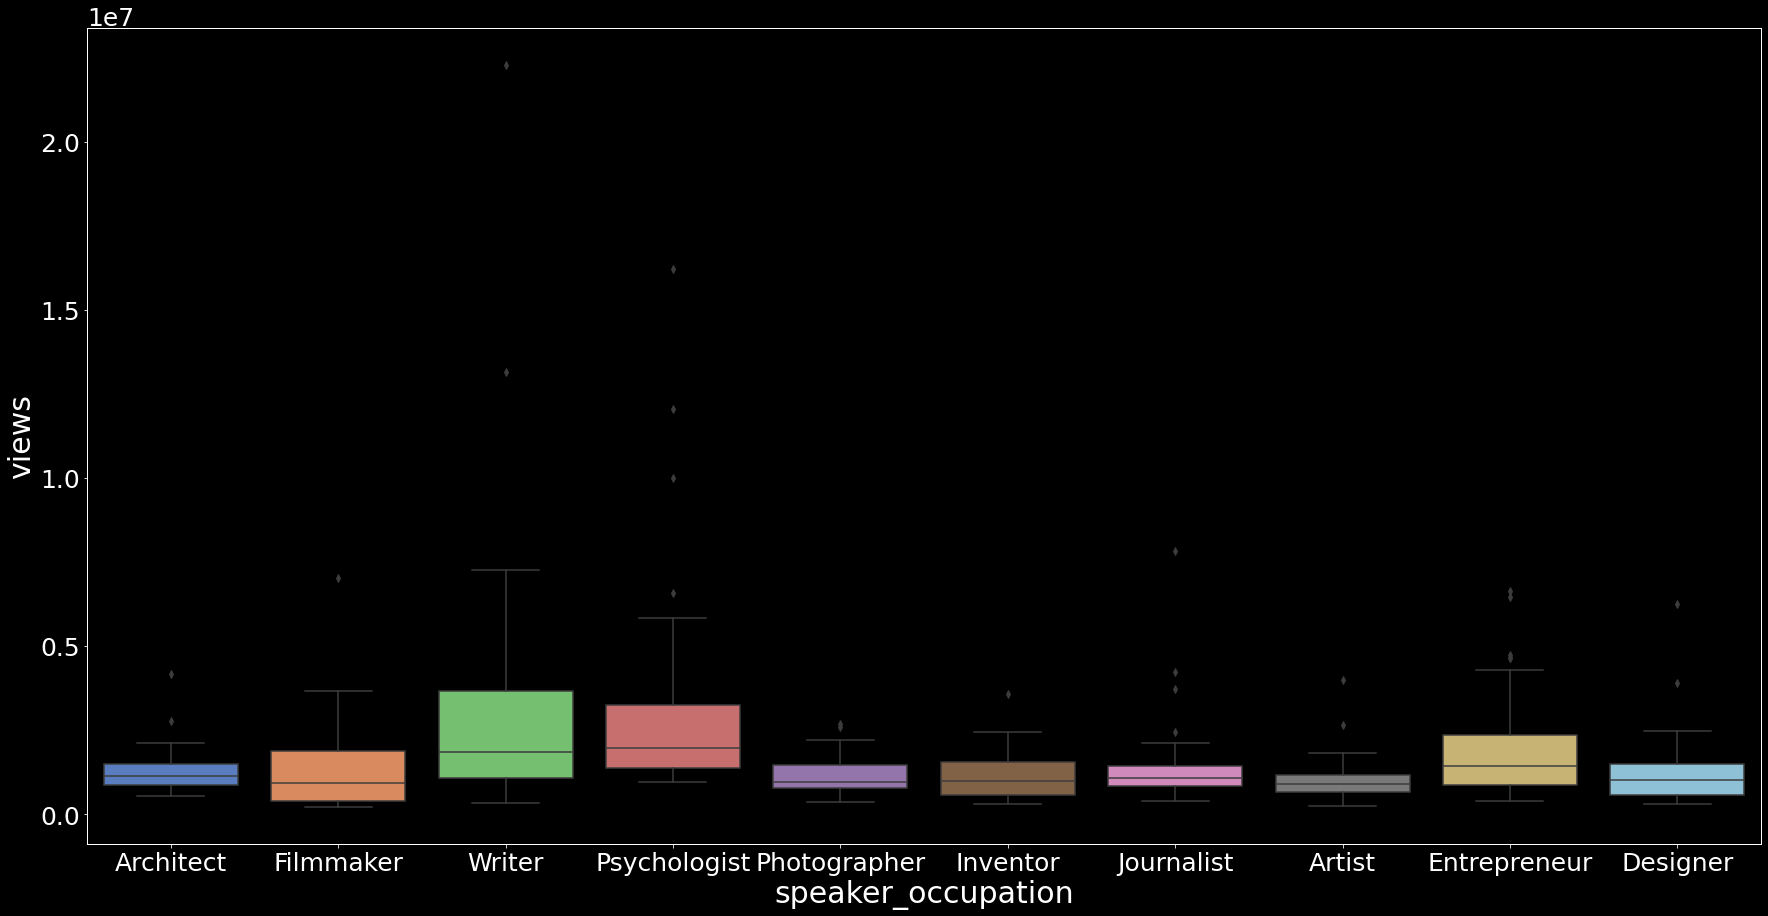

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(30, 15))
sns.boxplot(x='speaker_occupation', y='views', data=df[df['speaker_occupation'].isin(occupation_df_10['occupation'])], palette="muted", ax =ax)
plt.show()

In [ ]:
view_by_speaker_occupation = pd.DataFrame(df['views'].groupby(df['speaker_occupation']).sum())
view_by_speaker_occupation.reset_index(level=0, inplace=True)
mytable = view_by_speaker_occupation.sort_values(by='views', ascending=False)[:10]
mytable.reset_index(drop=True, inplace=True)
mytable

,speaker_occupation,views
0,Writer,133549303
1,Psychologist,90851398
2,Author/educator,61151284
3,Entrepreneur,61006231
4,Social psychologist,57943179
5,Leadership expert,48203767
6,Journalist,47711812
7,Vulnerability researcher,47145938
8,Designer,43294187
9,Neuroscientist,40585744


- Ken Robinson, Brene Brown and Hans Rosling are the most popular speaker in terms of views.
- Writer, Journalist, Author are the most popular occupations among the most popular talks.
- Among the most common occupations for TED talks, architect and filmmaker do not give as popular talks as other top occupations.
Insight:
Writer, journalist, Author give the most popular talks. They are not necessarily occupations with more chances for public speaking, instead they generally have diverse experience and good at sharing sympathy with the audience and they are good in delivering topic as well.

### Presentation Skills Vs Views

TED Talks are short presentations and require sophisticated presentation skills to not only interesting enough to draw audiences' attention, but also serious enough to deliver the ideas in a short amount of time. Presentation skills are doubtless important and should be one of the reasons why some talks are more popular than others. In this section, I'll explore how presentation skills relates to popularity based on the available data.

One presentation skill is to ask questions to the audience in order to draw their attention and make them more engaged. so one question here is TED Talks with titles containing question marks are more popular than plain titles?

In [ ]:
df['contain_ques_mark'] = 0
for i in range(df.shape[0]):
    string = df.loc[i, 'title']
    if "?" in string:
        df.loc[i, 'contain_ques_mark'] = 1


In [ ]:
df['contain_ques_mark'].sum()

203

Rank of views is defined as ranking all talks based on their number of views, with the most viewed talks rank number 1

In [ ]:
df['viewrank'] = df['views'].rank(ascending=False)

Text(0.5, 1.0, 'Rank of views distribution (W question mark in title)')

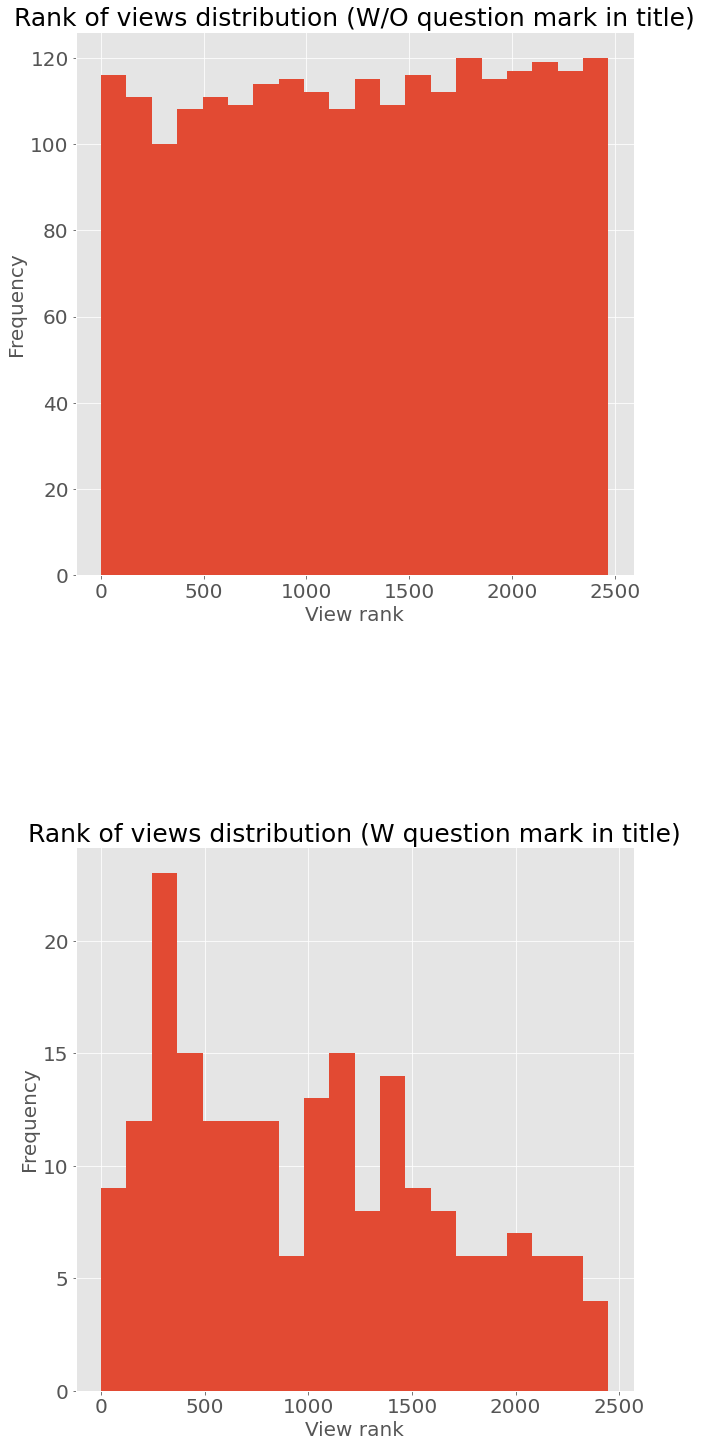

In [ ]:
fig = plt.figure(figsize=(10,25))
fig.subplots_adjust(hspace=.5)

ax1=fig.add_subplot(2,1,1)
ax1.hist(df[df['contain_ques_mark']==0]['viewrank'], bins=20)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_xlabel('View rank', fontsize=20)
ax1.set_ylabel('Frequency', fontsize=20)
ax1.set_title('Rank of views distribution (W/O question mark in title)', fontsize=25)

ax2=fig.add_subplot(2,1,2)
ax2.hist(df[df['contain_ques_mark']==1]['viewrank'], bins=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_xlabel('View rank', fontsize=20)
ax2.set_ylabel('Frequency', fontsize=20)
ax2.set_title('Rank of views distribution (W question mark in title)', fontsize=25)


talks with question mark in the title generally rank higher than other talks in terms of view numbers

### TED Talks presented in humorous ways are more popular?

Another presentation skill is to give presentations in humorous ways that stimulate laughter. The audiences may remember the presentation contents better on interesting talks than talks that are too serious. In this part of study, I'll explore deeper on presentation scripts and study the relationship between indicators of laughter and talks popularity.

In [ ]:
df['script_contain_Laughter'] = 0
for i in range(df.shape[0]):
    string = df.loc[i, 'transcript']
    if "Laughter" in string:
        df.loc[i, 'script_contain_Laughter'] = 1

In [ ]:
df['script_contain_Laughter'].sum()

1808

Text(0.5, 1.0, "Rank of views distribution (W 'laughter' in transcript)")

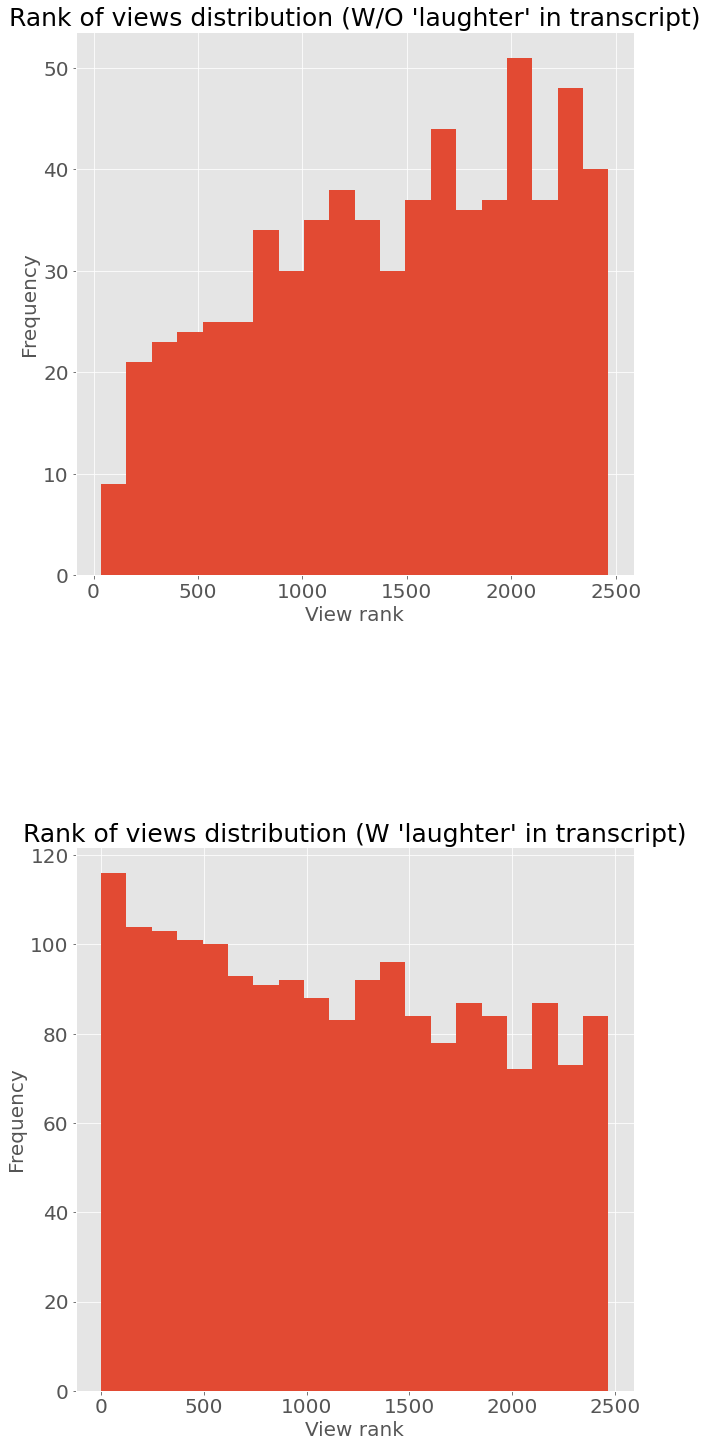

In [ ]:
fig = plt.figure(figsize=(10,25))
fig.subplots_adjust(hspace=.5)
ax1=fig.add_subplot(2,1,1)
ax1.hist(df[df['script_contain_Laughter']==0]['viewrank'], bins=20)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_xlabel('View rank', fontsize=20)
ax1.set_ylabel('Frequency', fontsize=20)
ax1.set_title("Rank of views distribution (W/O 'laughter' in transcript)", fontsize=25)

ax2=fig.add_subplot(2,1,2)
ax2.hist(df[df['script_contain_Laughter']==1]['viewrank'], bins=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_xlabel('View rank', fontsize=20)
ax2.set_ylabel('Frequency', fontsize=20)
ax2.set_title("Rank of views distribution (W 'laughter' in transcript)", fontsize=25)


Talks with "laughter" in the transcript generally rank higher than other talks in terms of views numbers.

For TED talks with a question mark in their titles, they are generally more popular in terms of views.
For TED talks with at least one ‘laughter’ in their transcripts, they are generally more often viewed.
Conclusions:
Presentation skills are indeed important and related to popularity.  Presenting in a humorous way helps draw attention, but the contents ultimately determine whether the audiences will be inspired or not.

## CONCLUSION:
